In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve


In [2]:
S0 = np.array([0,0.586*149597870700])   # m
V0 = np.array([54600,0])                # m s^-1
Ms = 1.989e30                               # kg
G = 6.6741e-11                              # m^3 kg^-1 s^-2
year = 31556926                             # s

In [5]:
def s_1(s,v,dt):
    return s+v*dt

def v_1(v,r,s,dt):
    return v - G*Ms*s*dt/(r**3)

def r_1(s):
    return math.sqrt(s[0]**2 + s[1]**2)

def s_v_array(v0,s0,dt,years):
    t = int(year*years/dt)+1
    s = np.zeros([t,2])
    v = np.zeros([t,2])
    t = np.arange(0,years*year,dt)
    
    s[0] = s0
    v[0] = v0

    for i in range(1,len(s)):
        s[i] = s_1(
            s[i-1],
            v[i-1],
            dt)
        v[i] = v_1(
            v[i-1],
            r_1(s[i-1]),
            s[i-1],
            dt)
    return (s,v, t)

In [9]:
s, v, t = s_v_array(V0,S0,2000,400)

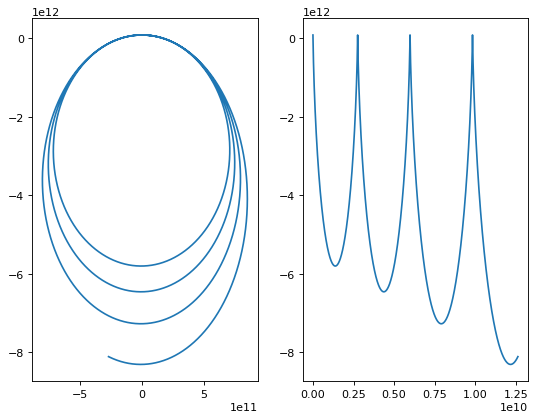

In [10]:
plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(1,2,1)
plt.plot(s.T[0],s.T[1])
plt.subplot(1,2,2)
plt.plot(t,s.T[1])


In [16]:

def k1(u):
    f1 = u[2]
    f2 = u[3]
    f3 = (-G*Ms/r_1(u[:2])**3)*u[0]
    f4 = (-G*Ms/r_1(u[:2])**3)*u[1]
    return np.array([f1,f2,f3,f4])

def k2(u,dt,K1):
    r = [u[0]+K1[0]*dt/2,u[1]+K1[1]*dt/2]
    f1 = u[2] + dt*K1[2]/2
    f2 = u[3] + dt*K1[3]/2
    f3 = (-G*Ms/r_1(r)**3)*(u[0]+K1[0]*dt/2)
    f4 = (-G*Ms/r_1(r)**3)*(u[1]+K1[1]*dt/2)
    return np.array([f1,f2,f3,f4])

def k3(u,dt,K2):
    r = [u[0]+K2[0]*dt/2,u[1]+K2[1]*dt/2]
    f1 = u[2] + K2[2]*dt/2
    f2 = u[3] + K2[3]*dt/2
    f3 = (-G*Ms/r_1(r)**3)*(u[0] + K2[0]*dt/2)
    f4 = (-G*Ms/r_1(r)**3)*(u[1] + K2[1]*dt/2)
    return np.array([f1,f2,f3,f4])

def k4(u,dt,K3):
    r = [u[0]+K3[0]*dt/2,u[1]+K3[1]*dt/2]
    f1 = u[2] + K3[2]*dt
    f2 = u[3] + K3[3]*dt
    f3 = (-G*Ms/r_1(u[:2])**3)*(u[0] + K3[0]*dt)
    f4 = (-G*Ms/r_1(u[:2])**3)*(u[1] + K3[1]*dt)
    return np.array([f1,f2,f3,f4])

def RK4(s0,v0,years,dt):
    t = int(year*years/dt)+1
    u = np.zeros([t,4])
    t = np.arange(0,years*year,dt)
    u[0] = np.append(s0,v0)
    for i in range(1,len(u)):
        K1 = k1(u[i-1])
        K2 = k2(u[i-1],dt, K1)
        K3 = k3(u[i-1],dt, K2)
        K4 = k4(u[i-1],dt, K3)
        u[i] = u[i-1] + dt*(K1 + 2*K2 + 2*K3 + K4)/6
    return (u, t)


In [17]:
u , t = RK4(S0,V0,400,2000)

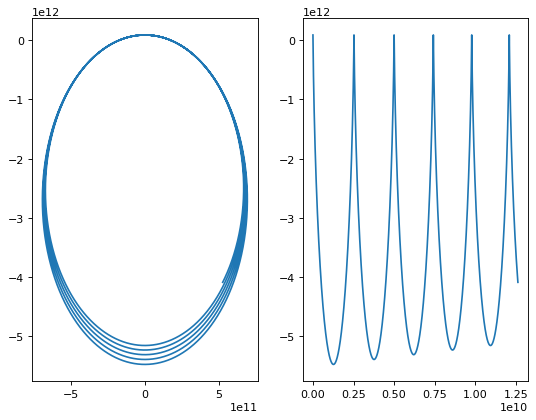

In [19]:
plt.figure(figsize=(8, 6), dpi=80)
plt.subplot(1,2,1)
plt.plot(u.T[0],u.T[1])
plt.subplot(1,2,2)
plt.plot(t,u.T[1])

In [14]:
u.T[3]

array([ 0.00000000e+00, -1.15387616e+10, -1.15387616e+10, ...,
       -1.15387616e+10, -1.15387616e+10, -1.15387616e+10])

np.array([[0],[0.586*149597870700]])